<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS5_W2024_students_0db1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<h1>Workshop #5 - Exploration and Promotion 🦄</h1>
</center>

# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in markdown blocks, and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 02/02/2025, 10:00
* For any questions regarding this workshop, contact [Eden](mailto:edens@campus.technion.ac.il).

# Introduction

In our next workshop, we will continue to explore recommendation system dynamics, and dive into new and interesting recommendation settings.

The goal of this homework is to explore one specific recommendation setting that appears in the real world in various forms.


## Imports

In [1]:
%pip install scikit-surprise

import itertools

import pandas as pd
import numpy as np
import scipy.stats
import IPython.display
import copy

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import surprise

from tqdm.auto import tqdm


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Workshop 4: Recap

## Basic definitions



### Notations

We use the following notations:
* Time is assumed to be discrete and denoted by $t\in\{0,1,\dots\}$
* The set of users is denoted by $U$.
* The set of "online users" requesting recommendation at time $t$ is denoted by $U_t \subseteq U$.
* The set of items is denoted by $X$.
* Rating given by user $u\in U$ to item $x \in X$ at time $t$ is denoted by $r_t(u,x)\in[1,5]$. User and item are not explicity specified when they are clear from context.
* Predicted ratings are denoted by $\hat{r}_t (u,x)$.
* Recommendations at time $t$ are denoted by $\{(u,x_u)\}_{u\in U_t}$.



### Metrics

#### Dynamic metrics
* The Average Rating of Recommended Items (*ARRI*) at time $t$ is defined as:
$$
\mathrm{ARRI} =
\frac{1}{\left|U_t\right|}
\sum_{u\in U_t}
r_t (u, x_u)
$$

* Rating RMSE at time $t$ is defined as:
$$
\mathrm{RMSE} =
\left(
\frac{1}{\left|U_t\right|}
\sum_{u\in U_t}
\left(
    \hat{r}_t (u, x_u) - r_t (u, x_u) \right)^2
\right)^{0.5}
$$

#### Aggregate metrics
For a given simulation run:
* The average ARRI is defined as:
$$
\bar{\mathrm{ARRI}} =
\frac{
    \sum_{t=1}^T
    \sum_{u\in U_t}
    r_t (u, x_u)
}{
    \sum_{t=1}^T |U_t|
}
$$

* The average RMSE is defined as:
$$
\bar{\mathrm{RMSE}} = \left(
\frac{
    \sum_{t=1}^T
    \sum_{u\in U_t}
    \left(\hat{r}_t (u, x_u) - r_t (u, x_u) \right)^2
}{
    \sum_{t=1}^T |U_t|
}
\right)^{0.5}
$$

#### Shannon entropy

For a given user $u$ being shown $n_u$ items, denote by $R_u=\left(k_1,\dots,k_{n_u}\right)\in{[K]}^{n_u}$ the list of item topics recommended to the user throughout the simulation run.

The [empirical distribution](https://en.wikipedia.org/wiki/Empirical_distribution_function) of topics for user $u$ is denoted by:

$$
p_u(k) = \frac{\text{number of occurrences of $k$ in $R_u$}}{n_u}
$$

The [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) of a discrete random variable:

$$
H(p) = -\sum_k p(k) \log_2 p(k)
$$

For a given run, the average entropy across users is:
$$
\bar{H} = \frac{1}{|U|} \sum_{u\in U} H(p_u)
$$


### Environment
An *environment* defines the population of users and the collection of available items. It specifies the users' behavior, their preferences and the way they change over time, how the users rate items, etc. In particular, the environments we use here are **stateful**.

In this workshop, environments expose the following interface:

* `__init__(...)` - Initialize environment using given parameters
* `get_initial_ratings()` - Returns a pandas DataFrame with initial ratings $\{(u_i, x_i, r_i)\}$. Useful for bootstrapping the recommendation algorithm and avoiding the "[cold-start](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)" problem.
* `get_online_users()` - Returns the set of online users $U_t\subseteq U$ that queried the system at the current time step $t$.
* `recommend(recommendations)` - Receives as input a list of tuples $R_t = \{ (u_i,x_i) \mid u_i \in U_t \} $, where each $u_i \in U_t$ is an online user, and $x_i$ is the item being recommended. Note that only unseen items can be recommended, and all online users must receive recommendations. The function returns the true ratings given by the users.


### Recommender

A *recommender* generates item recommendations to users based on past ratings.

In Workshop 4, we recommended the items with the highest predicted rating. Prediction algorithms use the [Surprise](https://surpriselib.com/) framework.



### Simulation
The simulation works in discrete time steps $t\in\{1,2,\dots\}$. At each step, only some of the users request a recommendation. We denote these users as *online users*. At time $0$, the recommender also receives initial observations to bootstrap the recommendation algorithm.


## Environments

### `TopicsStatic`

(Introduced in HW4)

The following environment is based on the `topics-static` environment introduced by [Krauth et. al. 2020](https://arxiv.org/abs/2011.07931).

* In the `TopicsStatic` environment, each item is assigned to one of $K$ topics and users prefer certain topics.
The preference of user $u$ for items of topic $k$
is initialized as $\pi(u, k) ∼ \mathrm{Uniform}(0.5, 5.5)$, while the topic
$k_x$ of item $x$ is chosen randomly from the set of all topics.

* When user $u$ is recommended item $x $ of topic $k_x$, they will rate the item as:
$$r_t(u,x) = \mathrm{clip}_{[1,5]}\left(\pi(u, k_x) + z \right)$$
where $z \sim N(0, \sigma^2)$ represents exogenous noise not modeled by the simulation, and $\mathrm{clip}_{[1,5]}$ truncates values to be between $1$ and $5$.
* Remark on notations: In this workshop, we slightly adapt notations and denote the Gaussian noise by $z$ of $\epsilon$ in order to avoid confusion with the $\varepsilon$-greedy policy discussed in Part 1 of this workshop.

### `TopicsDynamic`

(Introduced in WS4)

In `TopicsDynamic`, items are rated in the same way as `TopicsStatic`. In this setting however, user preferences change as a result of content consumption.
In particular, if item $x$ is recommended to user $u$ at time $t$, then their preferences are updated as:

$$
\pi_{t+1}(u,k)
= \begin{cases}
\mathrm{clip}_{[0.5,5.5]}\left(\pi_t(u,k) + a\right) & k = k_x \\
\mathrm{clip}_{[0.5,5.5]}\left(\pi_t(u,k) - \frac{a}{K-1}\right) & k \neq k_x
\end{cases}
$$

where $a$ is a fixed affinity parameter.

This environment is based on the `topics-dynamic` environment introduced by [Krauth et. al. 2020](https://arxiv.org/abs/2011.07931).

Implementation of the `TopicsDynamic` environment is provided below:

## Surprise

[Surprise](https://surpriselib.com/) is a Python library for building and analyzing recommender systems that deal with explicit rating data.

In particular, Surprise provides various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based, and many others.

1. Go over the introduction to Surprise in its [main homepage](https://surpriselib.com/) ("Overview", "Getting started" sections).
2. Go over the "[Basic usage](https://surprise.readthedocs.io/en/stable/getting_started.html#basic-usage)" section in the Surprise documentation.
3. The `surprise` library is already available in this notebook. (Surprise! 🥳)


## Code

Workshop 5 will use the same infrastructure we used in Workshop 4. The following cell contains the definitions of `TopicsStatic`, `TopicsDynamic`, and `trainset_from_df`. Run it to define the class of environments:

In [2]:
class TopicsStatic:
    topic_affinity_params = dict(
        low=0.5,
        high=5.5,
    )
    decision_noise_params = dict(
        scale=0.5,
    )
    rating_frequency = 0.2

    def __init__(self, n_users, n_items, n_topics, n_initial_ratings, random_state=None):
        """
        Initialize the environment.

        Parameters
        ----------
        n_users : int
            Number of users in the environment.

        n_items : int
            Number of items in the environment.

        n_topics : int
            Number of latent topics in the environment.

        n_initial_ratings : int
            Number of initial ratings available to the recommender before the
            simulation starts.

        random_state : int, default=None
            Random seed to use, if none is specified, a seed provided by the
            OS will be used.
        """
        self.n_users = n_users
        self.n_items = n_items
        self.all_users = [f'usr_{i}' for i in range(self.n_users)]
        self.all_items = [f'itm_{i}' for i in range(self.n_items)]
        self.n_topics = n_topics
        self.n_initial_ratings = n_initial_ratings
        self.rng = np.random.default_rng(random_state)
        # Assign topics to items
        self._item_topics = self.rng.integers(
            low=0,
            high=n_topics,
            size=n_items
        )
        # Initialize topics affinity matrix
        self._topic_affinity = self.rng.uniform(
            **self.topic_affinity_params,
            size=(n_users, n_topics),
        )
        # Initialize environment state
        self.t = 0
        self.last_online_users = None
        self.seen_items = {user_id: list() for user_id in self.all_users}
        self.initial_ratings_shown = False

    def _get_rating(self, user_id, item_id):
        """
        Calculate rating r_t(user_id, item_id).
        """
        assert item_id not in self.seen_items[user_id], (
            'Each item can only be shown once to each user'
        )
        user_internal_id = self.all_users.index(user_id)
        item_internal_id = self.all_items.index(item_id)
        self.seen_items[user_id].append(item_id)
        item_topic = self._item_topics[item_internal_id]
        affinity = self._topic_affinity[user_internal_id, item_topic]
        noise = self.rng.normal(**self.decision_noise_params)
        rating = np.clip(affinity+noise, 1, 5)
        return rating

    def _get_latent_topic(self, item_id):
        item_internal_id = self.all_items.index(item_id)
        return self._item_topics[item_internal_id]

    def get_initial_ratings(self):
        """
        Get initial ratings, to be used when initializing the recommender.

        Returns
        -------
        ratings_df : pandas.DataFrame
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for initial data is set to 0.
        """
        assert not self.initial_ratings_shown, (
            'Initial ratings can only be calculated once',
        )
        all_pairs = list(itertools.product(
            self.all_users,
            self.all_items,
        ))
        selected_pairs = self.rng.choice(
            a=all_pairs,
            size=self.n_initial_ratings,
            replace=False,
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in selected_pairs
        ]
        self.initial_ratings_shown = True
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)

    def get_online_users(self):
        """
        Returns the set of online users that queried the system at the
        current time step.

        Returns
        -------
        online_users: array of user_ids
        """
        assert self.last_online_users is None, (
            'Previous batch of online users must get recommendations'
        )
        n_online = self.rng.binomial(
            n=self.n_users,
            p=self.rating_frequency,
        )
        online_users = self.rng.choice(
            a=self.all_users,
            size=n_online,
            replace=False,
        )
        self.last_online_users = set(online_users)
        return online_users

    def recommend(self, recommendations):
        """
        Recommend items to users.

        Parameters
        ----------
        recommendations : list of (user_id, item_id) tuples.
            Each (user_id, item_id) tuple corresponds to an item recommended
            to an online user. Note that only unseen items can be recommended,
            and all online users must receive recommendations.

        Returns
        -------
        ratings_df : pandas.DataFrame
            True ratings given by the users.
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for recommendations is >= 1.
        """
        assert self.last_online_users is not None, (
            'Online users must be selected by calling get_online_users()'
        )
        assert len(recommendations)==len(self.last_online_users), (
            'Number of recommendations must match number of online users'
        )
        assert {user_id for user_id, _ in recommendations}==self.last_online_users, (
            'Users given recommendations must match online users'
        )
        assert all(item_id not in self.seen_items[user_id] for user_id, item_id in recommendations), (
            'Only unseen items can be recommended'
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in recommendations
        ]
        self.last_online_users = None
        self.t += 1
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)

    def get_unseen_items(self, user_id):
        """
        Get a list of items that the user didn't see yet.

        Parameters
        ----------
        user_id : int

        Returns
        -------
        unseen_items : list of int
            ids of unseen items.
        """
        return [
            item_id
            for item_id in self.all_items
            if item_id not in self.seen_items[user_id]
        ]


class TopicsDynamic(TopicsStatic):
    def __init__(self, a, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.a = a

    def recommend(self, recommendations):
        # Recommend and get ratings
        ratings_df = super().recommend(recommendations)
        # Update affinity
        for row in ratings_df.itertuples():
            user_internal_id = self.all_users.index(row.user_id)
            item_internal_id = self.all_items.index(row.item_id)

            # increase affinity for selected item topic
            selected_topic = self._item_topics[item_internal_id]
            self._topic_affinity[user_internal_id, selected_topic] += self.a
            # decrease affinity for other topics
            not_selected = np.arange(self.n_topics) != selected_topic
            self._topic_affinity[user_internal_id, not_selected] -= (
                self.a / (self.n_topics-1)
            )
            # clip
            self._topic_affinity[user_internal_id] = (
                self._topic_affinity[user_internal_id].clip(min=0.5, max=5.5)
            )
        # Return ratings dataframe
        return ratings_df


def trainset_from_df(df):
    """
    Convert DataFrame to Surprise training set.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns [user_id, item_id, rating]

    Returns
    -------
    trainset : surprise.Trainset
    """
    dataset = surprise.Dataset.load_from_df(
        df=df[['user_id','item_id','rating']],
        reader=surprise.Reader(rating_scale=(1,5)),
    )
    return dataset.build_full_trainset()


# Parameters

In [3]:
RANDOM_STATE = 1234

# TopicsDyamic
topics_params = {
    'n_users': 100,
    'n_items': 200,
    'n_topics': 10,
    'n_initial_ratings': 2000,
    'random_state': RANDOM_STATE,
}

# surprise.SVD
svd_model_params = {
    'n_factors': 16,
    'random_state': RANDOM_STATE,
}



# Part 1: The effects of exploration
Up until now, the recommendation policy we discussed in the workshop was *greedy*, in the sense that they always recommended items having the highest predicted value. In this section, we will explore other recommendation policies which are not fully greedy, and explore how they effect different performance metrics.


## 1.1 $\epsilon$-greedy



### The $\epsilon$-greedy algorithm
**$\epsilon$-greedy** is a simple non-greedy recommendation policy. For a given $\epsilon\in[0,1]$, the $\epsilon$-greedy policy recommends the item having the highest predicted score with probability $(1-\epsilon)$, and an item selected uniformly at random with probabilty $\epsilon$.


In [4]:
class EpsilonGreedyPolicy:
    def __init__(self, epsilon, random_state):
        """
        Initialize the recommendation algorithm.

        Parameters
        ----------
        epsilon : float
            epsilon parameter for epsilon-greedy recommendation.

        random_state : int, default=None
            Random seed to use, if none is specified, a seed provided by the
            OS will be used.
        """
        self.eps = epsilon
        self.rng = np.random.default_rng(random_state)

    def choose_items_to_recommend(self, candidate_items):
        """
        Choose item to recommend according to the epsilon-greedy algorithm.

        Parameters
        ----------
        candidate_items : list of (item_id, predicted_rating) tuples.
            Each (item_id, predicted_rating) tuple corresponds to a cadidate
            item.

        Returns
        -------
        item_id : int
            id of recommended item
        """
        if self.rng.random() > self.eps:
            # Greedy recommendation
            return max(candidate_items, key=lambda t: t[1])[0]
        else:
            # Recommend uniformly at random
            return self.rng.choice(list(candidate_items))[0]


For your convenience, we provide simulation code:

In [5]:
def simulate_recommendation_policy(env, cf_model, recommendation_policy, retraining_interval, num_steps):
    """
    Simulate recommendations policy.

    Parameters
    ----------
    env : TopicsStatic (or an instance of one of its subclasses)

    cf_model : surprise.AlgoBase

    recommendation_policy : EpsilonGreedyPolicy

    retraining_interval : int
        Retrain the prediction model every `retraining_interval` steps.

    num_steps : int
        Length of simulation.

    Returns
    -------
    recommendations_df : pandas.DataFrame
        pandas DataFrame with all recommendations. Each row represents a
        recommendation. Each recommendation is associated with a timestamp,
        user id, item id, predicted rating, actual rating, and latent topic.
    """

    results = []

    # Train CF model
    results = [env.get_initial_ratings()]
    cf_model.fit(trainset_from_df(results[0]))

    # Simulate dynamics
    for t in tqdm(range(num_steps)):
        online_users = env.get_online_users()
        recommendations = {}
        for user_id in online_users:
            predicted_ratings = {
                item_id: cf_model.predict(user_id, item_id).est
                for item_id in env.get_unseen_items(user_id)
            }
            selected_item = recommendation_policy.choose_items_to_recommend(
                candidate_items=predicted_ratings.items()
            )
            recommendations[(user_id, selected_item)] = predicted_ratings[selected_item]
        ratings = env.recommend(list(recommendations))
        results.append(
            ratings
            .assign(
                predicted_rating=lambda df: df.apply(
                    lambda row: recommendations[(row['user_id'], row['item_id'])],
                    axis=1,
                ),
                latent_topic=lambda df: df['item_id'].map(
                    lambda item_id: env._item_topics[env.all_items.index(item_id)]
                ),
            )
        )
        if retraining_interval and (t%retraining_interval==0):
            cf_model.fit(trainset_from_df(pd.concat(results)))
    return pd.concat(results)


# Example usage:
example_results_df = simulate_recommendation_policy(
    env=TopicsDynamic(
        a=0,
        **topics_params
    ),
    cf_model=surprise.SVD(
        **svd_model_params,
    ),
    recommendation_policy=EpsilonGreedyPolicy(
        epsilon=0.1,
        random_state=RANDOM_STATE,
    ),
    retraining_interval=1,
    num_steps=20,
)

example_results_df.sample(5)

  0%|          | 0/20 [00:00<?, ?it/s]

,user_id,item_id,rating,timestamp,predicted_rating,latent_topic
604,usr_88,itm_118,3.275256,0,NaN,NaN
1965,usr_74,itm_110,1.717050,0,NaN,NaN
1564,usr_90,itm_178,1.000000,0,NaN,NaN
1725,usr_70,itm_44,1.000000,0,NaN,NaN
1572,usr_26,itm_129,5.000000,0,NaN,NaN


### 1.1.1 Simulation
For each $\epsilon \in \{0, 0.3, 0.6, 0.9\}$ use the `simulate_recommendation_policy` function to run a simulation for $\epsilon$-greedy recommendation. Use the following parameters:
* `a=0.0`
* 100 time steps
* retraining every step (`retraining_interval=1`)
* `RANDOM_STATE` variable as the random state for the `EpsilonGreedyPolicy` instance

🔵 **Solution**:

In [6]:
epsilon_values = [0,0.3,0.6,0.9]
num_steps = 100
retraining_interval = 1

## YOUR SOLUTION
simulation_results = []

for epsilon in epsilon_values:
    results_df = simulate_recommendation_policy(
        env=TopicsDynamic(
            a=0.0,
            **topics_params
        ),
        cf_model=surprise.SVD(
            **svd_model_params,
        ),
        recommendation_policy=EpsilonGreedyPolicy(
            epsilon=epsilon,
            random_state=RANDOM_STATE,
        ),
        retraining_interval=retraining_interval,
        num_steps=num_steps,
    )
    simulation_results.append(results_df)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### 1.1.2 Analysis

What is the trade-off between average rating and content diversity?
Create a scatter plot illustrating the relations between ARRI and topic entropy:
* Each run simulated above will correspond to a single point on the scatter plot.
* The x axis of the plot should represent overall ARRI (as defined in the notations section above)
* The y axis of the plot should represent topic entropy (shannon entropy of latent topics for each user, averaged across users as in WS4).

The different points should be clearly labeled, either using a legend, or using the [`annotate`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html) function. We provide a utility function for your convenience.

🔵 **Solution**:

<Figure size 1000x600 with 0 Axes>

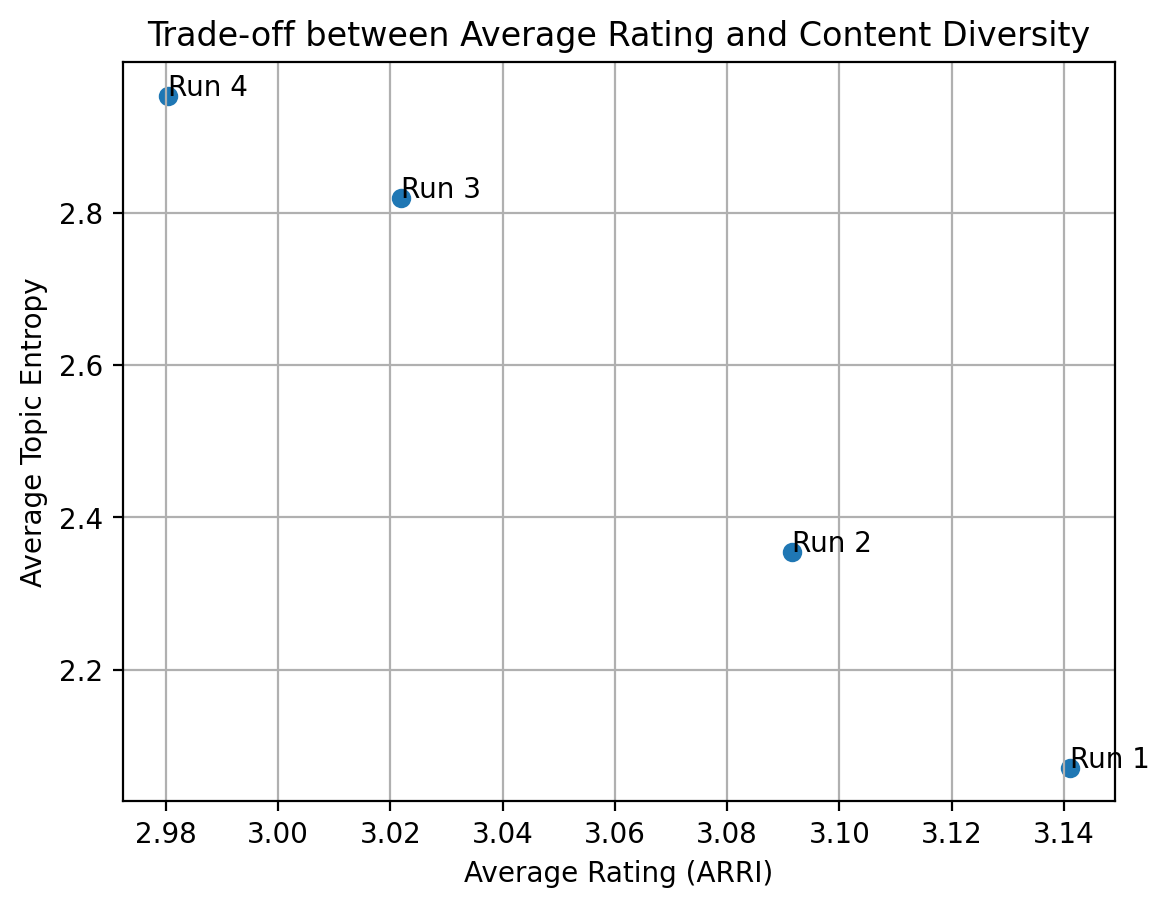

In [8]:
def plot_scatter_annotated(x,y,labels,xlabel,ylabel,ax=None):
    """
    Utility function - Create a scatter plot with labels for each point

    Parameters
    ----------
    x : np.array
        x value of each point

    y : np.array
        y value of each point

    labels : List of string
        label of each point

    ax : matplotlib.Axes (optional)
    """
    if ax==None:
        fig,ax = plt.subplots()
    ax.scatter(x,y)
    for x_val, y_val, label in zip(x,y,labels):
        ax.annotate(label, (x_val, y_val))
    ax.set(
        xlabel=xlabel,
        ylabel=ylabel,
    )
    return ax

## YOUR SOLUTION
# Get ARRI and topic entropy for each run
arri_values = []
entropy_values = []
labels = []

for i in range(len(simulation_results)):
    arri = simulation_results[i]['rating'].mean()
    arri_values.append(arri)
    
    # Calculate topic entropy averaged across users
    user_topic_counts = simulation_results[i].groupby('user_id')['latent_topic'].value_counts().unstack(fill_value=0)
    user_entropies = []
    
    for _, user_topics in user_topic_counts.iterrows():
        # Shannon entropy
        probs = user_topics / user_topics.sum()
        entropy = -np.sum(probs * np.log2(probs + 1e-10)) # add small epsilon to avoid log(0)
        user_entropies.append(entropy)
    
    avg_entropy = np.mean(user_entropies)
    entropy_values.append(avg_entropy)
    
    labels.append(f'Run {i+1}')

# Create scatter plot
plt.figure(figsize=(10, 6))
plot_scatter_annotated(
    x=arri_values,
    y=entropy_values,
    labels=labels,
    xlabel='Average Rating (ARRI)',
    ylabel='Average Topic Entropy'
)
plt.title('Trade-off between Average Rating and Content Diversity')
plt.grid(True)
plt.show()


Explain your results:

🔵 **Answer**:

When $\epsilon$ is 0, the agent is greedy and always recommends the item with the highest predicted rating. This results in a high ARRI score, but a low topic entropy, as the user is only exposed to a few topics.
As $\epsilon$ increases, the agent becomes more explorative, and the topic entropy increases, but the ARRI score decreases.
We create the enviorment with a=0, so the agent is not influenced by the topic affinity, meaning that we are in a static enviorment.
The obvious trade-off is between the ARRI score and the topic entropy, the more the $\epsilon$, the higher the topic entropy, and the lower the ARRI score.


## 1.2 Boredom




### The `TopicsDynamicWithBoredom` environment

In the ```TopicsStatic``` environment, a user's $u$ rating for an item $i$ at time $t$ is modeled as:
$$r_t(u,x) = \mathrm{clip}_{[1,5]}\left(\pi(u, k_x) + \varepsilon\right)$$

where $k_x$ is the topic of item $x$, $\pi$ is the latent affinity function, $\varepsilon$ is a random gaussian noise, and $clip_{[1,5]}$ turncates the score to be between $1$ and $5$.

In this part, you will explore what happens when users get *bored*.
Bordeom occurs when users are repeatedly recommended the same topic in a short time span.

Following the definitions in [Krauth et. al. 2020](https://arxiv.org/abs/2011.07931), we define an environment with boredom effects, relying on three parameters:
* Memory length $m$,
* Boredom threshold $\tau$
* Boredom penalty $\lambda$

If a user observes the same topic more than $\tau$ times within the last $m$ timesteps, their ratings is penalized by $\lambda$.
Specifically:
$$r_t(u,x) = \mathrm{clip}_{[1,5]}\left(\pi(u, k_x) - \lambda I_{m,\tau}(k_x) + \varepsilon\right)$$
where
$I_{m,\tau}(k_x)=1$ if topic $k_x$ was observed more than $\tau$ times within $m$ previous timesteps, and $0$ otherwise.

The `TopicsDynamicWithBoredom` inherits from `TopicsDynamic` and implements this environment:

In [9]:
class TopicsDynamicWithBoredom(TopicsDynamic):
    def __init__(self, boredom_memory_length, boredom_threshold, boredom_penalty, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.boredom_memory_length = boredom_memory_length
        self.boredom_threshold = boredom_threshold
        self.boredom_penalty = boredom_penalty

    def _get_rating(self, user_id, item_id):
        """
        Calculate rating r_t(user_id, item_id).
        """
        assert item_id not in self.seen_items[user_id], (
            'Each item can only be shown once to each user'
        )

        self.seen_items[user_id].append(item_id)
        user_internal_id = self.all_users.index(user_id)
        item_internal_id = self.all_items.index(item_id)
        item_topic = self._item_topics[item_internal_id]
        # Topic affinity
        affinity = self._topic_affinity[user_internal_id, item_topic]
        # Boredom penalty
        last_seen_items = self.seen_items[user_id][-self.boredom_memory_length:]
        last_seen_topics = [self._item_topics[self.all_items.index(itm)] for itm in last_seen_items]
        last_seen_topic_count = last_seen_topics.count(item_topic)
        penalty = self.boredom_penalty*(last_seen_topic_count>=self.boredom_threshold)
        # Noise
        noise = self.rng.normal(**self.decision_noise_params)
        # Final rating
        rating = np.clip(affinity-penalty+noise, 1, 5)
        return rating


### 1.2.1 Simulation
Repeat the simulation in exercise 1.1.1 using a `TopicsDynamicWithBoredom` environment with $m = 6$, $\tau = 4$, and $\lambda = 3$, with the rest of the parameters remaining the same.

Note: The arguments to ```Topics``` corresponding to $m, \tau, \lambda$ are ```memory_length, boredom_threshold, boredom_penalty``` respectively.

🔵 **Solution**:

In [10]:
boredom_environment_params = {
    'a': 0.0,
    'boredom_memory_length': 6,
    'boredom_threshold': 4,
    'boredom_penalty': 3,
    **topics_params
}

## YOUR SOLUTION
epsilon_values = [0,0.3,0.6,0.9]
num_steps = 100
retraining_interval = 1

## YOUR SOLUTION
simulation_results = []

for epsilon in epsilon_values:
    results_df = simulate_recommendation_policy(
        env=TopicsDynamicWithBoredom(
            **boredom_environment_params    
        ),
        cf_model=surprise.SVD(
            **svd_model_params,
        ),
        recommendation_policy=EpsilonGreedyPolicy(
            epsilon=epsilon,
            random_state=RANDOM_STATE,
        ),
        retraining_interval=retraining_interval,
        num_steps=num_steps,
    )
    simulation_results.append(results_df)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

### 1.2.2 Analysis

Repeat the analysis 1.1.2 for the boredom enviroment, and compare the two sets of results.

🔵 **Solution**:

<Figure size 1000x600 with 0 Axes>

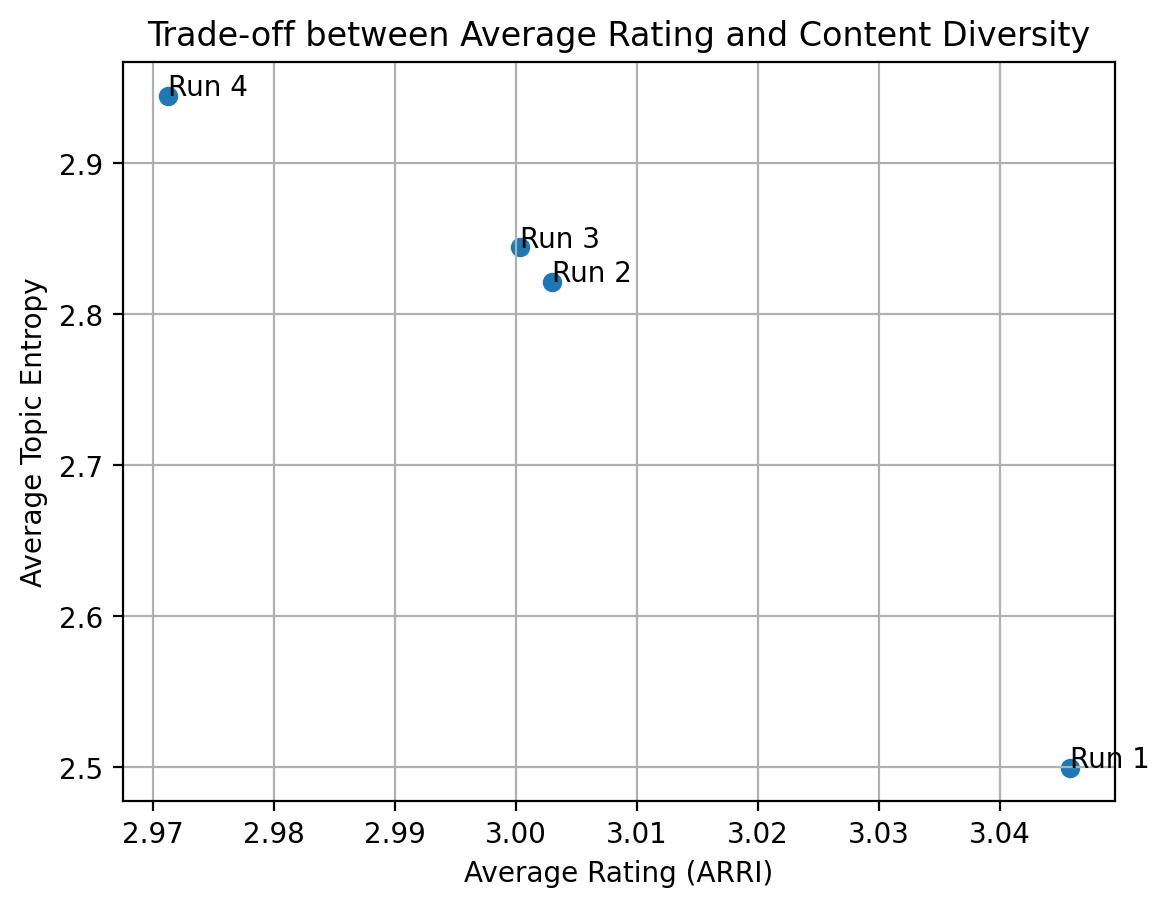

In [11]:
# Get ARRI and topic entropy for each run
arri_values = []
entropy_values = []
labels = []

for i in range(len(simulation_results)):
    arri = simulation_results[i]['rating'].mean()
    arri_values.append(arri)
    
    # Calculate topic entropy averaged across users
    user_topic_counts = simulation_results[i].groupby('user_id')['latent_topic'].value_counts().unstack(fill_value=0)
    user_entropies = []
    
    for _, user_topics in user_topic_counts.iterrows():
        # Shannon entropy
        probs = user_topics / user_topics.sum()
        entropy = -np.sum(probs * np.log2(probs + 1e-10)) # add small epsilon to avoid log(0)
        user_entropies.append(entropy)
    
    avg_entropy = np.mean(user_entropies)
    entropy_values.append(avg_entropy)
    
    labels.append(f'Run {i+1}')

# Create scatter plot
plt.figure(figsize=(10, 6))
plot_scatter_annotated(
    x=arri_values,
    y=entropy_values,
    labels=labels,
    xlabel='Average Rating (ARRI)',
    ylabel='Average Topic Entropy'
)
plt.title('Trade-off between Average Rating and Content Diversity')
plt.grid(True)
plt.show()


Explain your results:

🔵 **Answer**:

Given the parameters of the boredom environment, and assuming $\epsilon=0$, the agent is greedy and always recommends the item with the highest predicted rating. 
Because the agent learns every step, it can adapt to the boredom effect. And so the agent, even in $\epsilon=0$, will not recommend the same topic more than $\tau$ times in a row. This causes the topic entropy to be higher even in $\epsilon=0$.
We also notice the range of the ARRI score is smaller than in the static environment, this can be attributed to the boredom effect making the agent to have a less clear choices. This is probably why Run 1 is affected more than the other runs, ARRI wise. Also, the boredom effect is a penalty effect, so it might be that the choices leading to high ARRI scores won't work this time, resulting in lower ARRI scores even for a "perfect" agent.
Run 4 isn't changed. Beccause Run 4 has very high $\epsilon$ (0.9), the agent is very explorative (chooses almost uniformly), and so the boredom effect will most likely not be achieved.



# Part 2: Promotion markets

In this exercise, we will continue exploring the content supply market and its effect on users.



## Homework 5: Recap



### Setting
We will consider the `TopicsStatic` environment (introduced in the previous workshop), in which each item has a topic and users prefer certain topics over others. In this exercise, however, we introduce *suppliers* into the environment. Each supplier owns one topic (so that the number of  suppliers is equal to the number of topics $K$), and profits when users consume items of that topic:
Whenever an item from topic $k\in[K]$ is recommended by the system to some user $u$, supplier $k$ gets paid.

The recommendation system allows suppliers to influence recommendations through a *promotion system*: Before each time step, each supplier can place a bid of some amount; the higher the amount supplier $k$ bids, the more likely it is for the system to recommend to users items from topic $k$.

More specifically, at each timestep $t$:
1. Suppliers $1,\dots,K$ place bids $b_t^{(1)},\dots,b_t^{(K)} \ge 0$ to participate in the promotion process. They can choose how much to bid, but cannot bid more than they currently have.
2. The system sorts the suppliers by their bids, and ties are broken lexicographically. Denote the position of topic $k$ in the sorted list by $\mathrm{pos}_t(k)\in\{1,\dots,K\}$.
3. For each user, the system predicts the ratings of items $\hat{r}_t(u,x)$, as it is prediction based and
recommends the items with the highest predicted ratings.
4. For each rating prediction of an item of topic $k$, the system adds a promotion bias $\beta_k$ to the
prediction, where:
$$
\beta_t^{(k)}=B\left(2\frac{K-\mathrm{pos}_t(k)}{K-1} - 1\right)
$$
This way, the supplier who bid the highest ($\mathrm{pos}_t(k)=1$) will get a bias of $B$, the supplier who bid the lowest value ($\mathrm{pos}_t(k)=K$) will get a bias of $-B$, and the supplier who bid the median amount will get a bias of $0$. In our code, we refer to $B$ as the *promotion factor*.
5. After calculating the promotion bias terms, the system recommends items according to the modified predictions (original predictions with the added biases):
$$
x_u = \mathrm{argmax}_{x\in X} \hat{r}_t(u,x) + \beta_t^{(k_x)}
$$

6. The supplier of topic $k$ receives $m_t^{(k)}$ dollars, where:
$$
m_t^{(k)}=100\frac{\text{number of items of topic $k$ recommended}}{\text{number of recommendations in this step}}
$$

In the beginning of the simulation, all suppliers have $100. To simplify, at each time step, all
suppliers bid a random amount of money between 0 and 50% of the money they currently have.



After hearing about your outstanding success in Homework 5, your supervisor at the company caught you leaking bidding information to your uncle and fired
you. Now you don’t have any access to the recommender or the bids of other suppliers. Try to
maximize your uncle’s average income over time by coming up with a bidding strategy using
only publicly available information, such as the current budgets of all other suppliers, and the bids
and average ratings of the previous time steps (for this you will need to save them in the
environment or the recommender).
Explain your solution and its underlying rationale.


### Implementation


#### `BiddingAgent`
Suppliers' bidding policies are implemented by subclassing the `BiddingAgent` class:

In [ ]:
class BiddingAgent:
    """
    Generic class for simulating a bidding agent (supplier)
    """
    def __init__(self, initial_budget, topic_k, random_state=None):
        """
        Initialize the bidding agent.

        Parameters
        ----------
        initial_budget : float
            Initial budget (non-negative)

        topic_k : int
            Topic id corresponding to the agent (0,...,K-1)

        random_state : Seed. Valid input to `np.random.default_rng`.
        """
        assert initial_budget>=0, 'Initial budget must be nonnegative.'
        self.initial_budget = initial_budget
        self._remaining_budget = initial_budget
        self.topic_k = topic_k
        self.rng = np.random.default_rng(random_state)
        self.payment_history = []
        self.global_context = {}

    def calculate_bid(self, context=None):
        """
        Return the raw bid, to be implemented by subclasses.
        The `place_bid` function validates the value returned.

        Parameters
        ----------
        context : any
            a context parameter for informed decision-making.

        Returns
        -------
        bid : float
            bid for next promotion.
        """
        raise NotImplementedError

    def remaining_budget(self):
        """
        Get the remaining budget of the bidding agent.

        Returns
        -------
        remaining_budget : float
        """
        return self._remaining_budget

    def transfer_funds(self, m):
        """
        Transfer/receive funds resulting from recommendations.
        Negative value of `m` represents tranfer of funds from the agent
        to the system, and a positive value of `m` represents a payment
        from the system to the agent.

        Parameters
        ----------
        m : float
            Amount of pay.
        """
        assert self._remaining_budget+m>=0, (
            'Each payment must preserve a non-negative budget'
        )
        self._remaining_budget += m
        self.payment_history.append(m)

    def set_global_context(self, global_context):
        """
        Inform the agent about global simulation parameters, such as their
        identity and the items they supply.

        Parameters
        ----------
        global_context : dict
        """
        self.global_context = global_context




#### `RandomFractionBiddingAgent`

The `RandomFractionBiddingAgent` class implements the random bidding policy described in the previous section:

In [ ]:
class RandomFractionBiddingAgent(BiddingAgent):
    """
    Agent simulating a random bidding policy.
    At each step, suppliers of this type bid a random amount of money
    between 0 and half the money they currently have.
    """
    def calculate_bid(self, context):
        return self.rng.uniform(low=0.0,high=0.5)*self.remaining_budget()


#### `SuppliersGroup`

The `SuppliersGroup` describes the collective of bidding agents:

In [ ]:
class SuppliersGroup:
    def __init__(self, agents):
        """
        Initialize the suppliers group.

        Parameters
        ----------
        agents : list of BiddingAgent
        """
        self.agents = agents

    def calculate_bids(self, context):
        return [agent.calculate_bid(context) for agent in self.agents]

    def transfer_funds(self, payment_vector):
        for agent,payment in zip(self.agents, payment_vector):
            agent.transfer_funds(payment)

    def __len__(self):
        return len(self.agents)

    def __iter__(self):
        return iter(self.agents)

    def __getitem__(self,i):
        return self.agents[i]



#### Simulator

The `simulate_recommendations_with_bidding` function runs the simulation. It returns two DataFrames - One with recommendations and responses, and another with budgets and payments.

In [ ]:
def simulate_recommendations_with_bidding(
    env,
    cf_model,
    suppliers,
    num_steps,
    payment_per_step,
    promotion_factor,
):
    """
    Simulate recommendations with bidding.

    Parameters
    ----------
    env : TopicsStatic

    cf_model : surprise.AlgoBase

    num_steps : int
        Length of simulation.

    payment_per_step : float
        Total payment to suppliers per step

    promotion_factor : float
        Promotion factor B

    Returns
    -------
    recommendations_df : pandas.DataFrame
        pandas DataFrame with all recommendations. Each row represents a
        recommendation. Each recommendation is associated with a timestamp,
        user id, item id, predicted rating, actual rating, and latent topic.

    payments_df : pandas.DataFrame
        pandas DataFrame with all payment information. Each row represents
        the behavior of a supplier (and its consequences) for a given time
        step. Each row is associated with a timestamp, supplier id,
        supplier bid, attained position, boost factor, revenue, and
        remaining_budget.
    """
    assert isinstance(env, TopicsStatic), (
        'env must be an instance of TopicsStatic or one of its subclasses'
    )
    K = env.n_topics
    assert K == len(suppliers), (
        'Length of supplier list must match number of topics'
    )
    recommendation_results = []
    payment_results = []

    # Inform the suppliers about their identity
    for agent in suppliers:
        agent.set_global_context(global_context={
            'item_ids': [
                itm
                for i,itm in enumerate(env.all_items)
                if env._item_topics[i]==agent.topic_k
            ],
        })

    # Fit initial CF model
    recommendation_results = [env.get_initial_ratings()]
    cf_model.fit(trainset_from_df(recommendation_results[0]))

    # Simulate dynamics
    for t in tqdm(range(num_steps)):
        online_users = env.get_online_users()
        recommendations = {}
        # Calculate promotion factors
        bids = suppliers.calculate_bids(context={
            'online_users': online_users,
            'previous_ratings': (
                pd.concat(recommendation_results)
                .pipe(lambda df: df.drop('latent_topic',axis=1) if t>0 else df)
            ),
            'previous_bids': pd.DataFrame(payment_results),
        })
        for agent,bid in zip(suppliers,bids):
            assert bid>=0, 'Bids must be positive'
            agent.transfer_funds(-bid)
        pos = K-(scipy.stats.rankdata(bids, method='ordinal')-1)
        beta = promotion_factor*2*((K-pos)/(K-1) - 0.5)
        payment = np.zeros(K)

        # Recommend
        for user_id in online_users:
            # Predict ratings
            predicted_ratings = {
                item_id: cf_model.predict(user_id, item_id).est
                for item_id in env.get_unseen_items(user_id)
            }
            # Add promotion bias
            predicted_ratings_with_bias = {
                item_id: predicted_rating + beta[env._item_topics[env.all_items.index(item_id)]]
                for item_id, predicted_rating
                in predicted_ratings.items()
            }
            selected_item = max(
                predicted_ratings_with_bias.items(),
                key=lambda t: t[1],
            )[0]
            recommendations[(user_id, selected_item)] = predicted_ratings[selected_item]
            payment[env._item_topics[env.all_items.index(selected_item)]] += payment_per_step/len(online_users)

        ratings = env.recommend(list(recommendations))

        # Record results
        recommendation_results.append(
            ratings
            .assign(
                predicted_rating=lambda df: df.apply(
                    lambda row: recommendations[(row['user_id'], row['item_id'])],
                    axis=1,
                ),
                latent_topic=lambda df: df['item_id'].map(
                    lambda item_id: env._item_topics[env.all_items.index(item_id)]
                ),
            )
        )

        # Retrain
        cf_model.fit(trainset_from_df(pd.concat(recommendation_results)))

        # Pay and record remaining budgets
        for topic_k,agent in enumerate(suppliers):
            agent.transfer_funds(payment[topic_k])
            payment_results.append({
                'timestamp': t+1,
                'supplier': topic_k,  # supplier id
                'bid': bids[topic_k],  # supplier bid
                'position': pos[topic_k],  # pos_t(k)
                'boost': beta[topic_k],  # beta_t^k
                'revenue': payment[topic_k],  # payment made to supplier k
                'remaining_budget': agent.remaining_budget(),  # remaining budget
            })

    return (
        pd.concat(recommendation_results),  # recommendations_df
        pd.DataFrame(payment_results),  # payments_df
    )



## Simulation parameters

The following parameters will be used for simulation:

In [ ]:
initial_budget = 100
bidding_simulation_params = {
    'payment_per_step': 100,
    'promotion_factor': 3.0,
    'num_steps': 100,
}

### Example simulator run

The following code is equivalent to the simulation run in Homework 5:

In [ ]:
random_bid_recommendation_rng = np.random.default_rng(RANDOM_STATE)

(
    random_bid_recommendation_results_df,
    random_bid_payments_df,
) = simulate_recommendations_with_bidding(
    # environment
    env=TopicsDynamic(
        a=0.0,
        **topics_params
    ),
    # prediction model
    cf_model=surprise.SVD(
        **svd_model_params,
    ),
    # suppliers
    suppliers=SuppliersGroup(
        agents=[
            RandomFractionBiddingAgent(
                initial_budget=initial_budget,
                random_state=random_bid_recommendation_rng,
                topic_k=k,
            )
            for k in range(topics_params['n_topics'])
        ]
    ),
    # global simulation parameters (lengts, payment per step, promotion)
    **bidding_simulation_params
)

(
    random_bid_payments_df
    .pivot(
        index='timestamp',
        columns='supplier',
        values='remaining_budget',
    )
    .plot.line(
        title='Remaining budget over time for different suppliers',
        xlabel='Time ($t$)',
        ylabel='Remaining budget',
        figsize=(12,6),
    )
)

## 2.1 Outsider trading

After hearing about your stellar success in Homework #5, your supervisor at the company caught you leaking bidding information to your uncle and fired
you.

Now you don’t have any access to the recommender or the bids of other suppliers. Try to maximize your uncle’s average income over time by coming up with a bidding strategy using only publicly available information, such as the current budgets of all other suppliers, and the bids
and ratings from the previous time steps.

Implementation details:
* Public information is provided through the `context` variable given as argument to `BiddingAgent.calculate_bid`.
* In addition, you are informed about the list of items you own through the `BiddingAgent.global_context` dictionary.




In [ ]:
class PublicInfoBiddingAgent(BiddingAgent):
    def calculate_bid(self, context):
        # This function should return a positive float representing the
        # selected bid.

        # online_users is the list of current online users
        online_users = context['online_users']

        # ratings_df and payments_df are the intermediate values of the
        # dataframes returned by the `simulate_recommendations_with_bidding`
        # function. (excluding the `latent_topic` column in ratings_df)
        ratings_df = context['previous_ratings']
        payments_df = context['previous_bids']

        # The list of items you owned by this agent is available through
        # self.global_context
        item_ids = self.global_context['item_ids']

        ## YOUR SOLUTION


Analyze the performance of your new bidding heuristic. Simulation code is provided for convenience.

🔵 **Answer**:

In [ ]:
publicinfo_recommendation_rng = np.random.default_rng(RANDOM_STATE)
initial_budget = 100

(
    publicinfo_recommendation_results_df,
    publicinfo_payments_df,
) = simulate_recommendations_with_bidding(
    # environment
    env=TopicsDynamic(
        a=0.0,
        **topics_params
    ),
    # prediction model
    cf_model=surprise.SVD(
        **svd_model_params,
    ),
    # suppliers
    suppliers=SuppliersGroup(
        agents=(  # One PublicInfoBiddingAgent and K-1 random bidding agents
            [
                PublicInfoBiddingAgent(
                    initial_budget=300,
                    random_state=publicinfo_recommendation_rng,
                    topic_k=0,
                )
            ] + [
                RandomFractionBiddingAgent(
                    initial_budget=initial_budget,
                    random_state=publicinfo_recommendation_rng,
                    topic_k=k,
                )
                for k in range(1,topics_params['n_topics'])
            ]
        )
    ),
    # global simulation parameters (lengts, payment per step, promotion)
    **bidding_simulation_params
)


🔵 **Analysis**:

In [ ]:
## YOUR SOLUTION

Explain your solution and its underlying rationale. Support your claims with the appropriate data and plots.

🔵 **Answer**:

(YOUR SOLUTION)

## 2.2 A prisoner's dilemma?

Jealous of your ability to overcome challenging obstacles, your cousin decides to take the bidding agent that you just built and publish its code online!
As a result, all other suppliers start using the code you just built, undermining your competitive advantage.

Run the same simulation as above, but having all the suppliers use the `PublicInfoBiddingAgent` you implemented above.

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION


How does this behavior compare to the results of 2.1 and the results obtained in the homework?

Discuss the results. In particular, calculate and relate to the following:
* ARRI
* Content diversity across users and across time
* Total revenue of the system
* Average total revenue of each supplier
* Variance in total revenue across suppliers

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

🔵 **Explain your results**:

(YOUR SOLUTION)


What do you conclude about the dynamics? Why should bidders be encouraged to openly disclose their strategies? Why should they be encouraged to keep them secret?

🔵 **Answer**:

(YOUR SOLUTION)

## 2.3 Open-ended question: Designing promotion markets

Following the humiliating experience with your cousin, your old boss offers you the opportunity to design a new generation of content promotion systems after you promise not to engage in any more insider trading.

You are now the chief designer of *Promotion System 2.0™️*!

More formally, your job is to design a new promotion bias rule $\beta^{(k)}_t$ and a new payment rule $m^{(k)}_t$ (corresponding to the formal description in the "Setting" section above) that will achieve better societal outcomes.

Desired properties of promotion systems:
* Monotonicity with respect to bids - Increasing a bid increases the expected payment at the end of the round.
* User satisfaction - Measured in ARRI and/or content diversity.
* System revenue - The amount of money collected by the system throughout its run.

Your goal is to try to design a promotion rule that improves upon one of these factors without hurting the others. This can mean new functional forms for $\beta^{(k)}_t$ and $m^{(k)}_t$, or just a change of parameters. In any case, answers should be properly supported.




### 2.3.1 Plan

Before you implement, explain your ideas and the rationale behind them. Why do you expect them to work?

🔵 **Answer**:

(YOUR SOLUTION)



### 2.3.2 Implement

Implement the new promotion system by creating a modified version of the `simulate_recommendations_with_bidding` function.

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

### 2.3.3 Evaluate
Test the new implementation in two settings:
1. Homogeneous collection of `PublicInfoBiddingAgent` instances
2. A mixture of `PublicInfoBiddingAgent` and `RandomFractionBiddingAgent` instances

🔵 **Answer**:


In [ ]:
## YOUR SOLUTION

How do the results compare to the existing promotion mechanism? Support your claims with data.

🔵 **Answer**:

In [ ]:
## YOUR SOLUTION

(YOUR SOLUTION)

### 2.3.4 Conclude

Summarize - Who benefits from the promotion mechanism you proposed and how? Is there any party that is worse-off?

🔵 **Answer**:

(YOUR SOLUTION)